In [1]:
import os
from pathlib import Path

from itertools import chain, product

import datetime

import math
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar

import datetime
import pymmwr

from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

# https://github.com/reichlab/timeseriesutils
from timeseriesutils import featurize

In [2]:
# config settings

# date of forecast generation
forecast_date = datetime.date.today()

# next Saturday: weekly forecasts are relative to this date
ref_date = forecast_date - datetime.timedelta((forecast_date.weekday() + 2) % 7 - 7)
print(f'reference date = {ref_date}')

# include measures of level among features?
incl_level_feats = False

# maximum forecast horizon
max_horizon = 5

# bagging setup
num_bags = 100
bag_frac_samples = 0.7

# quantile levels at which to generate predictions
q_levels = [0.01, 0.025, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35,
            0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80,
            0.85, 0.90, 0.95, 0.975, 0.99]
q_labels = ['0.01', '0.025', '0.05', '0.1', '0.15', '0.2', '0.25', '0.3', '0.35',
            '0.4', '0.45', '0.5', '0.55', '0.6', '0.65', '0.7', '0.75', '0.8',
            '0.85', '0.9', '0.95', '0.975', '0.99']

reference date = 2024-01-06


In [3]:
def date_to_ew_str(row, date_col_name='wk_end_date'):
    ew = pymmwr.date_to_epiweek(datetime.date.fromisoformat(row[date_col_name]))
    # ew_str = pd.Series(str(ew.year) + str(ew.week))
    ew_str = str(ew.year) + str(ew.week)
    return ew_str



# convert epi week to season week
def convert_epiweek_to_season_week(epiweek):
  """Convert season and epiweek to season and season week.
  Args:
      epiweek in format 'yyyyww'
  Return:
      season_week: integer between 1 and 52
  """
  epiweek_year = epiweek.str[:4].astype(int)
  epiweek_week = epiweek.str[4:].astype(int)
  
  season_week = epiweek_week - 30

  update_inds = (season_week <= 0)
  season_week[update_inds] = season_week[update_inds] + \
    [pymmwr.epiweeks_in_year(int(epiweek_year[update_inds].values[i]) - 1) for i in range(np.sum(update_inds))]
  
  return season_week



def convert_epiweek_to_season(epiweek):
  """Convert season and epiweek to season and season week.
  Args:
      epiweek in format 'yyyyww'
  Return:
      season: string in format '2018/19'
  """
  epiweek_year = epiweek.str[:4].astype(int)
  epiweek_week = epiweek.str[4:].astype(int)
  
  update_inds = (epiweek_week <= 30)
  epiweek_year = epiweek_year - update_inds
  season = epiweek_year.astype(str)
  season = season + '/' + (season.str[-2:].astype(int) + 1).astype(str)
  
  return season



def load_fips_mappings():
  return pd.read_csv('../../data-raw/fips-mappings/fips_mappings.csv')



def load_flusurv_rates_2022_23():
  dat = pd.read_csv('../../data-raw/influenza-flusurv/flusurv-rates/flusurv-rates-2022-23.csv',
                    encoding='ISO-8859-1',
                    engine='python')
  dat.columns = dat.columns.str.lower()
  
  dat = dat.loc[(dat['age category'] == 'Overall') &
                (dat['sex category'] == 'Overall') &
                (dat['race category'] == 'Overall')]
  
  dat = dat.loc[~((dat.catchment == 'Entire Network') &
                  (dat.network != "FluSurv-NET"))]

  dat['location'] = dat['catchment']
  dat['agg_level'] = np.where(dat['location'] == 'Entire Network', 'national', 'site')
  dat['season'] = dat['year'].str.replace('-', '/')
  epiweek = dat['mmwr-year'].astype(str) + dat['mmwr-week'].astype(str)
  dat['season_week'] = convert_epiweek_to_season_week(epiweek)
  dat['wk_end_date'] = dat.apply(
    lambda x: pymmwr.epiweek_to_date(pymmwr.Epiweek(year=x['mmwr-year'],
                                                    week=x['mmwr-week'],
                                                    day=7))
                                    .strftime("%Y-%m-%d"),
      axis=1)
  dat['wk_end_date'] = pd.to_datetime(dat['wk_end_date'])
  dat['inc'] = dat['weekly rate ']
  dat = dat[['agg_level', 'location', 'season', 'season_week', 'wk_end_date', 'inc']]
  
  return dat



def load_flusurv_rates_base(seasons=None,
                            locations=['California', 'Colorado', 'Connecticut', 'Entire Network',
                                      'Georgia', 'Maryland', 'Michigan', 'Minnesota', 'New Mexico',
                                      'New York - Albany', 'New York - Rochester', 'Ohio', 'Oregon',
                                      'Tennessee', 'Utah'],
                            age_labels=['0-4 yr', '5-17 yr', '18-49 yr', '50-64 yr', '65+ yr', 'Overall']
                            ):
  # read flusurv data and do some minimal preprocessing
  dat = pd.read_csv('../../data-raw/influenza-flusurv/flusurv-rates/old-flusurv-rates.csv',
                    encoding='ISO-8859-1',
                    engine='python')
  dat.columns = dat.columns.str.lower()
  dat['season'] = dat.sea_label.str.replace('-', '/')
  dat['inc'] = dat.weeklyrate
  dat['location'] = dat['region']
  dat['agg_level'] = np.where(dat['location'] == 'Entire Network', 'national', 'site')
  dat = dat[(dat.age_label.isin(age_labels)) & (dat.location.isin(locations))]
  if seasons is not None:
    dat = dat[dat.season.isin(seasons)]
  
  dat = dat.sort_values(by=['wk_end'])
  
  dat['wk_end_date'] = pd.to_datetime(dat['wk_end'])
  dat = dat[['agg_level', 'location', 'season', 'season_week', 'wk_end_date', 'inc']]
  
  dat = pd.concat(
    [dat, load_flusurv_rates_2022_23()],
    axis = 0
  )

  dat['source'] = 'flusurvnet'
  
  return dat


def load_one_us_census_file(f):
  dat = pd.read_csv(f, engine='python', dtype={'STATE': str})
  dat = dat.loc[(dat['NAME'] == 'United States') | (dat['STATE'] != '00'),
                (dat.columns == 'STATE') | (dat.columns.str.startswith('POPESTIMATE'))]
  dat = dat.melt(id_vars = 'STATE', var_name='season', value_name='pop')
  dat.rename(columns={'STATE': 'location'}, inplace=True)
  dat.loc[dat['location'] == '00', 'location'] = 'US'
  dat['season'] = dat['season'].str[-4:]
  dat['season'] = dat['season'] + '/' + (dat['season'].str[-2:].astype(int) + 1).astype(str)
  
  return dat


def load_us_census(fillna = True):
  files = [
    '../../data-raw/us-census/nst-est2019-alldata.csv',
    '../../data-raw/us-census/NST-EST2022-ALLDATA.csv']
  us_pops = pd.concat([load_one_us_census_file(f) for f in files], axis=0)
  
  fips_mappings = pd.read_csv('../../data-raw/fips-mappings/fips_mappings.csv')
  
  hhs_pops = us_pops.query("location != 'US'") \
    .merge(
        fips_mappings.query("location != 'US'") \
            .assign(hhs_region=lambda x: 'Region ' + x['hhs_region'].astype(int).astype(str)),
        on='location',
        how = 'left'
    ) \
    .groupby(['hhs_region', 'season']) \
    ['pop'] \
    .sum() \
    .reset_index() \
    .rename(columns={'hhs_region': 'location'})
  
  dat = pd.concat([us_pops, hhs_pops], axis=0)
  
  if fillna:
    all_locations = dat['location'].unique()
    all_seasons = [str(y) + '/' + str(y+1)[-2:] for y in range(1997, 2024)]
    full_result = pd.DataFrame.from_records(product(all_locations, all_seasons))
    full_result.columns = ['location', 'season']
    dat = full_result.merge(dat, how='left', on=['location', 'season']) \
      .set_index('location') \
      .groupby(['location']) \
      .bfill() \
      .groupby(['location']) \
      .ffill() \
      .reset_index()
  
  return dat


def load_hosp_burden():
  burden_estimates = pd.read_csv(
    '../../data-raw/burden-estimates/burden-estimates.csv',
    engine='python')

  burden_estimates.columns = ['season', 'hosp_burden']

  #burden_estimates['hosp_burden'] = burden_estimates['hosp_burden'].astype(int)

  burden_estimates['season'] = burden_estimates['season'].str[:4] + '/' + burden_estimates['season'].str[7:9]

  return burden_estimates


def calc_hosp_burden_adj():
  dat = load_flusurv_rates_base(
    seasons = ['20' + str(yy) + '/' + str(yy+1) for yy in range(10, 23)],
    locations= ['Entire Network'],
    age_labels = ['Overall']
  )

  burden_adj = dat[dat.location == 'Entire Network'] \
    .groupby('season')['inc'] \
    .sum()
  burden_adj = burden_adj.reset_index()
  burden_adj.columns = ['season', 'cum_rate']

  us_census = load_us_census().query("location == 'US'").drop('location', axis=1)
  burden_adj = pd.merge(burden_adj, us_census, on='season')

  burden_estimates = load_hosp_burden()
  burden_adj = pd.merge(burden_adj, burden_estimates, on='season')

  burden_adj['reported_burden_est'] = burden_adj['cum_rate'] * burden_adj['pop'] / 100000
  burden_adj['adj_factor'] = burden_adj['hosp_burden'] / burden_adj['reported_burden_est']

  return burden_adj


def fill_missing_flusurv_dates_one_location(location_df):
  df = location_df.set_index('wk_end_date') \
    .asfreq('W-sat') \
    .reset_index()
  fill_cols = ['agg_level', 'location', 'season', 'pop', 'source']
  df[fill_cols] = df[fill_cols].fillna(axis=0, method='ffill')
  return df


def load_flusurv_rates(burden_adj=True,
                       locations=['California', 'Colorado', 'Connecticut', 'Entire Network',
                                'Georgia', 'Maryland', 'Michigan', 'Minnesota', 'New Mexico',
                                'New York - Albany', 'New York - Rochester', 'Ohio', 'Oregon',
                                'Tennessee', 'Utah']
                       ):
  # read flusurv data and do some minimal preprocessing
  dat = load_flusurv_rates_base(
    seasons = ['20' + str(yy) + '/' + str(yy+1) for yy in range(10, 23)],
    locations = locations,
    age_labels = ['Overall']
  )
  
  # if requested, make adjustments for overall season burden
  if burden_adj:
    hosp_burden_adj = calc_hosp_burden_adj()
    dat = pd.merge(dat, hosp_burden_adj, on='season')
    dat['inc'] = dat['inc'] * dat['adj_factor']
  
  # fill in missing dates
  gd = dat.groupby('location')
  
  dat = pd.concat(
    [fill_missing_flusurv_dates_one_location(df) for _, df in gd],
    axis = 0)
  dat = dat[['agg_level', 'location', 'season', 'season_week', 'wk_end_date', 'inc', 'source']]
  
  return dat


def load_who_nrevss_positive():
  dat = pd.read_csv('../../data-raw/influenza-who-nrevss/who-nrevss.csv',
                    encoding='ISO-8859-1',
                    engine='python')
  dat = dat[['region_type', 'region', 'year', 'week', 'season', 'season_week', 'percent_positive']]
  
  dat.rename(columns={'region_type': 'agg_level', 'region': 'location'},
             inplace=True)
  dat['agg_level'] = np.where(dat['agg_level'] == 'National',
                              'national',
                              dat['agg_level'].str[:-1].str.lower())
  return dat


def load_ilinet(response_type='rate',
                scale_to_positive=True,
                drop_pandemic_seasons=True,
                burden_adj=False):
  # read ilinet data and do some minimal preprocessing
  files = ['../../data-raw/influenza-ilinet/ilinet.csv',
           '../../data-raw/influenza-ilinet/ilinet_hhs.csv',
           '../../data-raw/influenza-ilinet/ilinet_state.csv']
  dat = pd.concat(
    [ pd.read_csv(f, encoding='ISO-8859-1', engine='python') for f in files ],
    axis = 0)
  
  if response_type == 'rate':
    dat['inc'] = np.where(dat['region_type'] == 'States',
                          dat['unweighted_ili'],
                          dat['weighted_ili'])
  else:
    dat['inc'] = dat.ilitotal

  dat['wk_end_date'] = pd.to_datetime(dat['week_start']) + pd.Timedelta(6, 'days')
  dat = dat[['region_type', 'region', 'year', 'week', 'season', 'season_week', 'wk_end_date', 'inc']]
  
  dat.rename(columns={'region_type': 'agg_level', 'region': 'location'},
             inplace=True)
  dat['agg_level'] = np.where(dat['agg_level'] == 'National',
                              'national',
                              dat['agg_level'].str[:-1].str.lower())
  dat = dat.sort_values(by=['season', 'season_week'])
  
  # for early seasons, drop out-of-season weeks with no reporting
  early_seasons = [str(yyyy) + '/' + str(yyyy + 1)[2:] for yyyy in range(1997, 2002)]
  early_in_season_weeks = [w for w in range(10, 43)]
  first_report_season = ['2002/03']
  first_report_in_season_weeks = [w for w in range(10, 53)]
  dat = dat[
    (dat.season.isin(early_seasons) & dat.season_week.isin(early_in_season_weeks)) |
    (dat.season.isin(first_report_season) & dat.season_week.isin(first_report_in_season_weeks)) |
    (~dat.season.isin(early_seasons + first_report_season))]
  
  # region 10 data prior to 2010/11 is bad, drop it
  dat = dat[
    ~((dat['location'] == 'Region 10') & (dat['season'] < '2010/11'))
  ]
  
  if scale_to_positive:
    dat = pd.merge(
      left=dat,
      right=load_who_nrevss_positive(),
      how='left',
      on=['agg_level', 'location', 'season', 'season_week'])
    dat['inc'] = dat['inc'] * dat['percent_positive'] / 100.0
    dat.drop('percent_positive', axis=1)

  if drop_pandemic_seasons:
    dat.loc[dat['season'].isin(['2008/09', '2009/10', '2020/21', '2021/22']), 'inc'] = np.nan

  # if requested, make adjustments for overall season burden
  # if burden_adj:
  #   hosp_burden_adj = calc_hosp_burden_adj()
  #   dat = pd.merge(dat, hosp_burden_adj, on='season')
  #   dat['inc'] = dat['inc'] * dat['adj_factor']

  dat = dat[['agg_level', 'location', 'season', 'season_week', 'wk_end_date', 'inc']]
  dat['source'] = 'ilinet'
  return dat



def load_hhs(rates=True):
  dat = pd.read_csv("../../data-raw/influenza-hhs/hhs.csv")
  dat.rename(columns={'date': 'wk_end_date'}, inplace=True)

  ew_str = dat.apply(date_to_ew_str, axis=1)
  dat['season'] = convert_epiweek_to_season(ew_str)
  dat['season_week'] = convert_epiweek_to_season_week(ew_str)
  dat = dat.sort_values(by=['season', 'season_week'])
  
  if rates:
    pops = load_us_census()
    dat = dat.merge(pops, on = ['location', 'season'], how='left') \
      .assign(inc=lambda x: x['inc'] / x['pop'] * 100000)

  dat['wk_end_date'] = pd.to_datetime(dat['wk_end_date'])
  
  dat['agg_level'] = np.where(dat['location'] == 'US', 'national', 'state')
  dat = dat[['agg_level', 'location', 'season', 'season_week', 'wk_end_date', 'inc']]
  dat['source'] = 'hhs'
  return dat



def get_season_hol(start_year):
  holiday_cal = USFederalHolidayCalendar()
  hol = holiday_cal.holidays(
    start=datetime.datetime(year=start_year, month=7, day=1),
    end=datetime.datetime(year=start_year+1, month=6, day=1),
    return_name=True)
    
  hol = hol.reset_index()
  hol.columns = ['date', 'holiday']
  hol = hol.loc[hol['holiday'].isin(['Thanksgiving', 'Christmas'])]
  
  hol['season'] = str(start_year) + '/' + str(start_year + 1)[-2:]
  
  return hol



def convert_datetime_to_season_week(row, date_col_name):
  ew = pymmwr.date_to_epiweek(row[date_col_name].date())
  ew_str = pd.Series(str(ew.year) + str(ew.week))
  return convert_epiweek_to_season_week(ew_str)



def get_holidays():
  hol = pd.concat([get_season_hol(sy) for sy in range(1997, 2024)],
                  ignore_index=True)
  hol['season_week'] = hol.apply(convert_datetime_to_season_week, axis=1, date_col_name='date')
  
  return hol[['season', 'holiday', 'date', 'season_week']]


In [4]:
def load_data():
  us_census = load_us_census()
  fips_mappings = pd.read_csv('../../data-raw/fips-mappings/fips_mappings.csv')
  
  df_hhs = load_hhs()
  df_hhs['inc'] = df_hhs['inc'] + 0.75**4
  # df_hhs.loc[df_hhs['inc'] < 0.75**4, 'inc'] = 0.75**4
  
  df_ilinet_full = load_ilinet()
  # df_ilinet_full.loc[df_ilinet_full['inc'] < np.exp(-7), 'inc'] = np.exp(-7)
  df_ilinet_full['inc'] = (df_ilinet_full['inc'] + np.exp(-7)) * 4
  
  # aggregate ilinet sites in New York to state level,
  # mainly to facilitate adding populations
  ilinet_nonstates = ['National', 'Region 1', 'Region 2', 'Region 3',
                      'Region 4', 'Region 5', 'Region 6', 'Region 7',
                      'Region 8', 'Region 9', 'Region 10']
  df_ilinet_by_state = df_ilinet_full \
    .loc[(~df_ilinet_full['location'].isin(ilinet_nonstates)) &
         (df_ilinet_full['location'] != '78')] \
    .assign(state = lambda x: np.where(x['location'].isin(['New York', 'New York City']),
                                       'New York',
                                       x['location'])) \
    .assign(state = lambda x: np.where(x['state'] == 'Commonwealth of the Northern Mariana Islands',
                                       'Northern Mariana Islands',
                                       x['state'])) \
    .merge(
      fips_mappings.rename(columns={'location': 'fips'}),
      left_on='state',
      right_on='location_name') \
    .groupby(['state', 'fips', 'season', 'season_week', 'wk_end_date', 'source']) \
    .apply(lambda x: pd.DataFrame({'inc': [np.mean(x['inc'])]})) \
    .reset_index() \
    .drop(columns = ['state', 'level_6']) \
    .rename(columns = {'fips': 'location'}) \
    .assign(agg_level = 'state')
  
  df_ilinet_nonstates = df_ilinet_full.loc[df_ilinet_full['location'].isin(ilinet_nonstates)].copy()
  df_ilinet_nonstates['location'] = np.where(df_ilinet_nonstates['location'] == 'National',
                                             'US',
                                             df_ilinet_nonstates['location'])
  df_ilinet = pd.concat(
    [df_ilinet_nonstates, df_ilinet_by_state],
    axis = 0)
  
  df_flusurv_by_site = load_flusurv_rates()
  # df_flusurv_by_site.loc[df_flusurv_by_site['inc'] < np.exp(-3), 'inc'] = np.exp(-3)
  df_flusurv_by_site['inc'] = (df_flusurv_by_site['inc'] + np.exp(-3)) / 2.5
  
  # aggregate flusurv sites in New York to state level,
  # mainly to facilitate adding populations
  df_flusurv_by_state = df_flusurv_by_site \
    .loc[df_flusurv_by_site['location'] != 'Entire Network'] \
    .assign(state = lambda x: np.where(x['location'].isin(['New York - Albany', 'New York - Rochester']),
                                       'New York',
                                       x['location'])) \
    .merge(
      fips_mappings.rename(columns={'location': 'fips'}),
      left_on='state',
      right_on='location_name') \
    .groupby(['fips', 'season', 'season_week', 'wk_end_date', 'source']) \
    .apply(lambda x: pd.DataFrame({'inc': [np.mean(x['inc'])]})) \
    .reset_index() \
    .drop(columns = ['level_5']) \
    .rename(columns = {'fips': 'location'}) \
    .assign(agg_level = 'state')
  
  df_flusurv_us = df_flusurv_by_site.loc[df_flusurv_by_site['location'] == 'Entire Network'].copy()
  df_flusurv_us['location'] = 'US'
  df_flusurv = pd.concat(
    [df_flusurv_us, df_flusurv_by_state],
    axis = 0)
  
  df = pd.concat(
    [df_hhs, df_ilinet, df_flusurv],
    axis=0).sort_values(['source', 'location', 'wk_end_date'])
  
  # log population
  df = df.merge(us_census, how='left', on=['location', 'season'])
  df['log_pop'] = np.log(df['pop'])
  
  # process response variable:
  # - fourth root transform to stabilize variability
  # - divide by location- and source- specific 95th percentile
  # - center relative to location- and source- specific mean
  #   (note non-standard order of center/scale)
  df['inc_4rt'] = (df['inc'] + 0.01)**0.25
  df['inc_4rt_scale_factor'] = df \
    .assign(inc_4rt_in_season = lambda x: np.where((x['season_week'] < 10) | (x['season_week'] > 45),
                                                   np.nan,
                                                   x['inc_4rt'])) \
    .groupby(['source', 'location'])['inc_4rt_in_season'] \
    .transform(lambda x: x.quantile(0.95))
  
  df['inc_4rt_cs'] = df['inc_4rt'] / (df['inc_4rt_scale_factor'] + 0.01)
  df['inc_4rt_center_factor'] = df \
    .assign(inc_4rt_cs_in_season = lambda x: np.where((x['season_week'] < 10) | (x['season_week'] > 45),
                                                   np.nan,
                                                   x['inc_4rt_cs'])) \
    .groupby(['source', 'location'])['inc_4rt_cs_in_season'] \
    .transform(lambda x: x.mean())
  df['inc_4rt_cs'] = df['inc_4rt_cs'] - df['inc_4rt_center_factor']
  
  return(df)

In [5]:
df = load_data()
df

,agg_level,location,season,season_week,wk_end_date,inc,source,pop,log_pop,inc_4rt,inc_4rt_scale_factor,inc_4rt_cs,inc_4rt_center_factor
0,state,06,2010/11,10.0,2010-10-09,0.192732,flusurvnet,37319502.0,17.435027,0.671013,1.547258,-0.178518,0.609412
1,state,06,2010/11,11.0,2010-10-16,0.192732,flusurvnet,37319502.0,17.435027,0.671013,1.547258,-0.178518,0.609412
2,state,06,2010/11,12.0,2010-10-23,0.019915,flusurvnet,37319502.0,17.435027,0.415883,1.547258,-0.342350,0.609412
3,state,06,2010/11,13.0,2010-10-30,0.192732,flusurvnet,37319502.0,17.435027,0.671013,1.547258,-0.178518,0.609412
4,state,06,2010/11,14.0,2010-11-06,0.019915,flusurvnet,37319502.0,17.435027,0.415883,1.547258,-0.342350,0.609412
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57820,national,US,2023/24,3.0,2023-08-19,0.055589,ilinet,333287557.0,19.624516,0.506068,1.578296,-0.256336,0.574959
57821,national,US,2023/24,4.0,2023-08-26,0.059984,ilinet,333287557.0,19.624516,0.514339,1.578296,-0.251129,0.574959
57822,national,US,2023/24,5.0,2023-09-02,0.061600,ilinet,333287557.0,19.624516,0.517283,1.578296,-0.249275,0.574959
57823,national,US,2023/24,6.0,2023-09-09,0.061344,ilinet,333287557.0,19.624516,0.516821,1.578296,-0.249566,0.574959


In [6]:
np.sort(df['location'].unique())

array(['01', '02', '04', '05', '06', '08', '09', '10', '11', '12', '13',
       '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25',
       '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '44', '45', '46', '47', '48',
       '49', '50', '51', '53', '54', '55', '56', '69', '72', '78',
       'Region 1', 'Region 10', 'Region 2', 'Region 3', 'Region 4',
       'Region 5', 'Region 6', 'Region 7', 'Region 8', 'Region 9', 'US'],
      dtype=object)

<AxesSubplot:xlabel='season_week', ylabel='inc_4rt_cs'>

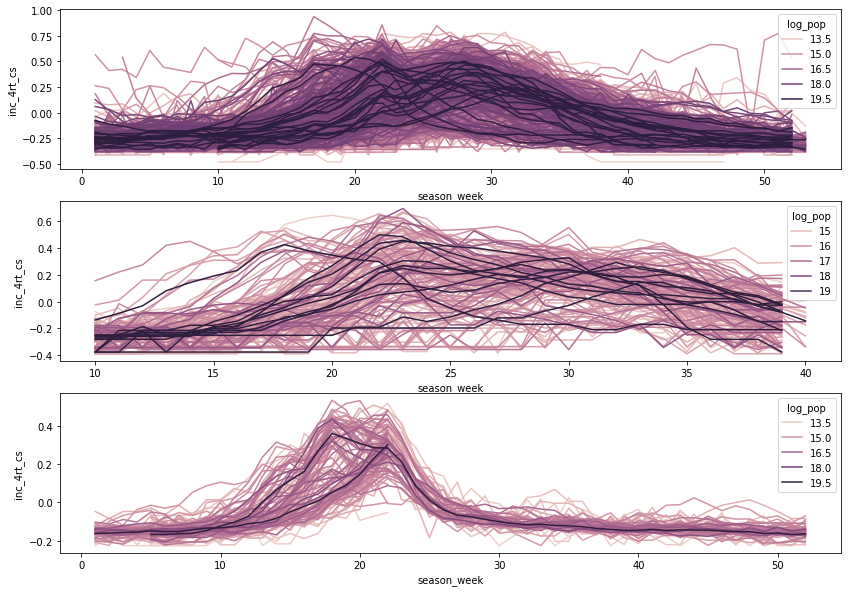

In [7]:
fig, ax = plt.subplots(3, 1)
fig.set_size_inches(14, 10)

ili_to_plot = df.loc[df['source'] == 'ilinet'].assign(season_loc = lambda x: x['season'] + '_' + x['location'])
sns.lineplot(data=ili_to_plot,
             x='season_week',
             y='inc_4rt_cs',
             units='season_loc',
             hue='log_pop',
             estimator=None,
             ci=None,
             ax=ax[0])

flusurv_to_plot = df.loc[df['source'] == 'flusurvnet'].assign(season_loc = lambda x: x['season'] + '_' + x['location'])
sns.lineplot(data=flusurv_to_plot,
             x='season_week',
             y='inc_4rt_cs',
             units='season_loc',
             hue='log_pop',
             estimator=None,
             ci=None,
             ax=ax[1])

hhs_to_plot = df.loc[df['source'] == 'hhs'].assign(season_loc = lambda x: x['season'] + '_' + x['location'])
sns.lineplot(data=hhs_to_plot,
             x='season_week',
             y='inc_4rt_cs',
             units='season_loc',
             hue='log_pop',
             estimator=None,
             ci=None,
             ax=ax[2])


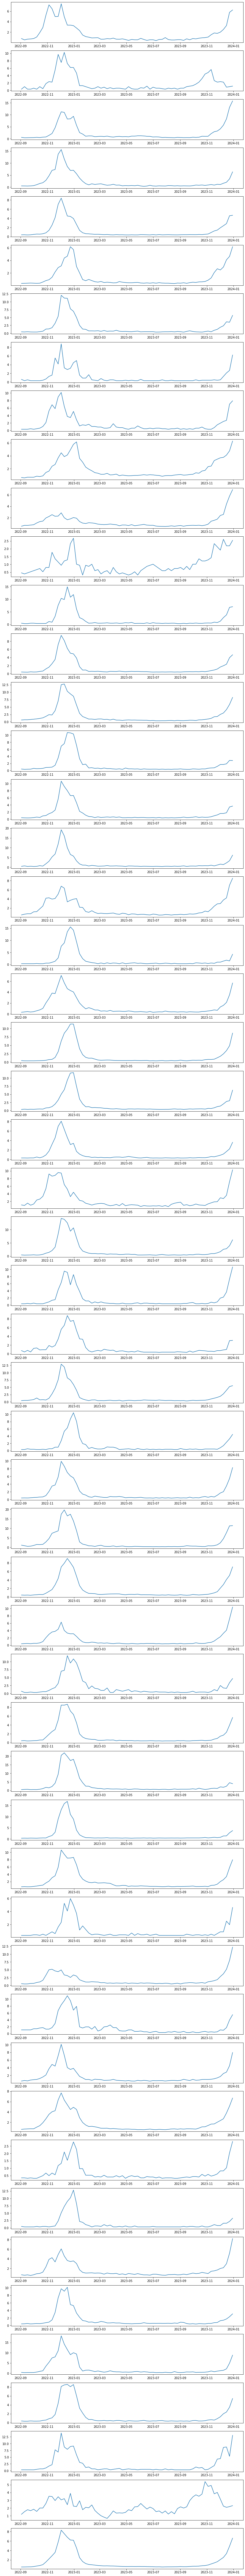

In [8]:
n_loc = len(hhs_to_plot['location'].unique())

fig, ax = plt.subplots(n_loc, 1)
fig.set_size_inches(14, 3*n_loc)

for i, loc in enumerate(hhs_to_plot['location'].unique()):
    loc_dat_hhs = hhs_to_plot.loc[hhs_to_plot['location'] == loc]
    ax[i].plot(loc_dat_hhs['wk_end_date'], loc_dat_hhs['inc'])


# Calculate features

### Misc. features based on date and location variables

In [9]:
# we already have incidence (transformed scale), season week and log population
feat_names = ['inc_4rt_cs', 'season_week', 'log_pop']

# one-hot encodings of data source, agg_level, and location
for c in ['source', 'agg_level', 'location']:
    ohe = pd.get_dummies(df[c], prefix=c)
    df = pd.concat([df, ohe], axis=1)
    feat_names = feat_names + list(ohe.columns)

# season week relative to christmas
df = df.merge(
    get_holidays() \
      .query("holiday == 'Christmas'") \
      .drop(columns=['holiday', 'date']) \
      .rename(columns={'season_week': 'xmas_week'}),
    how='left',
    on='season') \
  .assign(delta_xmas = lambda x: x['season_week'] - x['xmas_week'])

feat_names = feat_names + ['delta_xmas']

### Features summarizing time series within each source/location

In [10]:
df, new_feat_names = featurize.featurize_data(
    df, group_columns=['source', 'location'],
    features = [
        {
            'fun': 'windowed_taylor_coefs',
            'args': {
                'columns': 'inc_4rt_cs',
                'taylor_degree': 2,
                'window_align': 'trailing',
                'window_size': [4, 6],
                'fill_edges': False
            }
        },
        {
            'fun': 'windowed_taylor_coefs',
            'args': {
                'columns': 'inc_4rt_cs',
                'taylor_degree': 1,
                'window_align': 'trailing',
                'window_size': [3, 5],
                'fill_edges': False
            }
        },
        {
            'fun': 'rollmean',
            'args': {
                'columns': 'inc_4rt_cs',
                'group_columns': ['location'],
                'window_size': [2, 4]
            }
        }
    ])
feat_names = feat_names + new_feat_names

df, new_feat_names = featurize.featurize_data(
    df, group_columns=['source', 'location'],
    features = [
        {
            'fun': 'lag',
            'args': {
                'columns': ['inc_4rt_cs'] + new_feat_names,
                'lags': [1, 2]
            }
        }
    ])
feat_names = feat_names + new_feat_names

print(df)
print(feat_names)

      agg_level location   season  season_week wk_end_date       inc  \
0         state       06  2010/11         10.0  2010-10-09  0.192732   
1         state       06  2010/11         11.0  2010-10-16  0.192732   
2         state       06  2010/11         12.0  2010-10-23  0.019915   
3         state       06  2010/11         13.0  2010-10-30  0.192732   
4         state       06  2010/11         14.0  2010-11-06  0.019915   
...         ...      ...      ...          ...         ...       ...   
57820  national       US  2023/24          3.0  2023-08-19  0.055589   
57821  national       US  2023/24          4.0  2023-08-26  0.059984   
57822  national       US  2023/24          5.0  2023-09-02  0.061600   
57823  national       US  2023/24          6.0  2023-09-09  0.061344   
57824  national       US  2023/24          7.0  2023-09-16  0.066607   

           source          pop    log_pop   inc_4rt  ...  \
0      flusurvnet   37319502.0  17.435027  0.671013  ...   
1      flusurvn

In [11]:
feat_names

['inc_4rt_cs',
 'season_week',
 'log_pop',
 'source_flusurvnet',
 'source_hhs',
 'source_ilinet',
 'agg_level_hhs region',
 'agg_level_national',
 'agg_level_state',
 'location_01',
 'location_02',
 'location_04',
 'location_05',
 'location_06',
 'location_08',
 'location_09',
 'location_10',
 'location_11',
 'location_12',
 'location_13',
 'location_15',
 'location_16',
 'location_17',
 'location_18',
 'location_19',
 'location_20',
 'location_21',
 'location_22',
 'location_23',
 'location_24',
 'location_25',
 'location_26',
 'location_27',
 'location_28',
 'location_29',
 'location_30',
 'location_31',
 'location_32',
 'location_33',
 'location_34',
 'location_35',
 'location_36',
 'location_37',
 'location_38',
 'location_39',
 'location_40',
 'location_41',
 'location_42',
 'location_44',
 'location_45',
 'location_46',
 'location_47',
 'location_48',
 'location_49',
 'location_50',
 'location_51',
 'location_53',
 'location_54',
 'location_55',
 'location_56',
 'location_69',
 '

In [12]:
# if requested, drop features that involve absolute level
if not incl_level_feats:
  level_feats = ['inc_4rt_cs', 'inc_4rt_cs_lag1', 'inc_4rt_cs_lag2'] + \
                [f for f in feat_names if f.find('taylor_d0') > -1] + \
                [f for f in feat_names if f.find('inc_4rt_cs_rollmean') > -1]
  feat_names = [f for f in feat_names if f not in level_feats]

feat_names

['season_week',
 'log_pop',
 'source_flusurvnet',
 'source_hhs',
 'source_ilinet',
 'agg_level_hhs region',
 'agg_level_national',
 'agg_level_state',
 'location_01',
 'location_02',
 'location_04',
 'location_05',
 'location_06',
 'location_08',
 'location_09',
 'location_10',
 'location_11',
 'location_12',
 'location_13',
 'location_15',
 'location_16',
 'location_17',
 'location_18',
 'location_19',
 'location_20',
 'location_21',
 'location_22',
 'location_23',
 'location_24',
 'location_25',
 'location_26',
 'location_27',
 'location_28',
 'location_29',
 'location_30',
 'location_31',
 'location_32',
 'location_33',
 'location_34',
 'location_35',
 'location_36',
 'location_37',
 'location_38',
 'location_39',
 'location_40',
 'location_41',
 'location_42',
 'location_44',
 'location_45',
 'location_46',
 'location_47',
 'location_48',
 'location_49',
 'location_50',
 'location_51',
 'location_53',
 'location_54',
 'location_55',
 'location_56',
 'location_69',
 'location_72',
 

In [13]:
# import importlib
# featurize = importlib.reload(featurize)

# last date with observed data
# last_obs_date = pd.to_datetime(df.groupby(['location', 'pathogen_covid'])['date'].max().min())
# print(f'last_obs_date: {last_obs_date}')

# how far out to forecast to get to 28 days after due date
# due_date = forecast_date
# extra_horizons_rel_obs = (due_date - last_obs_date.date()).days
# effective_horizon_rel_obs = max_horizon + extra_horizons_rel_obs

# add forecast targets
df_with_pred_targets, new_feat_names = featurize.featurize_data(
    df, group_columns=['source', 'location'],
    features = [
        {
            'fun': 'horizon_targets',
            'args': {
                'columns': 'inc_4rt_cs',
                'horizons': [(i+1) for i in range(max_horizon)]
            }
        }
    ])
feat_names = feat_names + new_feat_names

# we will model the differences between the prediction target and the most
# recent observed value
df_with_pred_targets['delta_target'] = df_with_pred_targets['inc_4rt_cs_target'] - df_with_pred_targets['inc_4rt_cs']

print(new_feat_names)
print(df_with_pred_targets)

['horizon']
      agg_level location   season  season_week wk_end_date       inc  \
0         state       06  2010/11         10.0  2010-10-09  0.192732   
1         state       06  2010/11         11.0  2010-10-16  0.192732   
2         state       06  2010/11         12.0  2010-10-23  0.019915   
3         state       06  2010/11         13.0  2010-10-30  0.192732   
4         state       06  2010/11         14.0  2010-11-06  0.019915   
...         ...      ...      ...          ...         ...       ...   
57820  national       US  2023/24          3.0  2023-08-19  0.055589   
57821  national       US  2023/24          4.0  2023-08-26  0.059984   
57822  national       US  2023/24          5.0  2023-09-02  0.061600   
57823  national       US  2023/24          6.0  2023-09-09  0.061344   
57824  national       US  2023/24          7.0  2023-09-16  0.066607   

           source          pop    log_pop   inc_4rt  ...  \
0      flusurvnet   37319502.0  17.435027  0.671013  ...   
1  

In [14]:
list(df_with_pred_targets.columns)

['agg_level',
 'location',
 'season',
 'season_week',
 'wk_end_date',
 'inc',
 'source',
 'pop',
 'log_pop',
 'inc_4rt',
 'inc_4rt_scale_factor',
 'inc_4rt_cs',
 'inc_4rt_center_factor',
 'source_flusurvnet',
 'source_hhs',
 'source_ilinet',
 'agg_level_hhs region',
 'agg_level_national',
 'agg_level_state',
 'location_01',
 'location_02',
 'location_04',
 'location_05',
 'location_06',
 'location_08',
 'location_09',
 'location_10',
 'location_11',
 'location_12',
 'location_13',
 'location_15',
 'location_16',
 'location_17',
 'location_18',
 'location_19',
 'location_20',
 'location_21',
 'location_22',
 'location_23',
 'location_24',
 'location_25',
 'location_26',
 'location_27',
 'location_28',
 'location_29',
 'location_30',
 'location_31',
 'location_32',
 'location_33',
 'location_34',
 'location_35',
 'location_36',
 'location_37',
 'location_38',
 'location_39',
 'location_40',
 'location_41',
 'location_42',
 'location_44',
 'location_45',
 'location_46',
 'location_47',
 '

In [15]:
df_with_pred_targets['wk_end_date'].max()

Timestamp('2023-12-30 00:00:00')

In [16]:
df_with_pred_targets['horizon']

0        1
1        1
2        1
3        1
4        1
        ..
57820    5
57821    5
57822    5
57823    5
57824    5
Name: horizon, Length: 289125, dtype: int64

In [17]:
# keep only rows that are in-season
df_with_pred_targets = df_with_pred_targets.query("season_week >= 5 and season_week <= 45")

In [18]:
# "test set" df used to generate look-ahead predictions
df_test = df_with_pred_targets \
    .loc[df_with_pred_targets.wk_end_date == df_with_pred_targets.wk_end_date.max()] \
    .copy()
x_test = df_test[feat_names]

# "train set" df for model fitting; target value non-missing
df_train = df_with_pred_targets.loc[~df_with_pred_targets['delta_target'].isna().values]
x_train = df_train[feat_names]
y_train = df_train['delta_target']

In [19]:
df_test

,agg_level,location,season,season_week,wk_end_date,inc,source,pop,log_pop,inc_4rt,...,inc_4rt_cs_taylor_d0_w5t_sNone_lag2,inc_4rt_cs_taylor_d1_w5t_sNone_lag1,inc_4rt_cs_taylor_d1_w5t_sNone_lag2,inc_4rt_cs_rollmean_w2_lag1,inc_4rt_cs_rollmean_w2_lag2,inc_4rt_cs_rollmean_w4_lag1,inc_4rt_cs_rollmean_w4_lag2,inc_4rt_cs_target,horizon,delta_target
5028,state,01,2023/24,22.0,2023-12-30,6.228556,hhs,5074296.0,15.439698,1.580415,...,0.111674,0.059470,0.029011,0.194552,0.103351,0.124790,0.062533,NaN,1,NaN
5098,state,02,2023/24,22.0,2023-12-30,1.134310,hhs,733583.0,13.505696,1.034275,...,-0.036732,-0.043092,-0.037179,-0.083586,-0.017180,-0.009059,0.024145,NaN,1,NaN
5168,state,04,2023/24,22.0,2023-12-30,15.752873,hhs,7359197.0,15.811461,1.992548,...,0.249265,0.076227,0.053467,0.326060,0.228173,0.240148,0.163348,NaN,1,NaN
5238,state,05,2023/24,22.0,2023-12-30,6.357835,hhs,3045637.0,14.929221,1.588539,...,0.002454,0.044216,0.029967,0.056314,-0.007674,0.000545,-0.042837,NaN,1,NaN
5308,state,06,2023/24,22.0,2023-12-30,4.659293,hhs,39029342.0,17.479824,1.469985,...,0.176166,0.054889,0.040711,0.227187,0.156618,0.172740,0.113711,NaN,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8388,state,54,2023/24,22.0,2023-12-30,8.822701,hhs,1775156.0,14.389399,1.723945,...,0.012328,0.059939,0.034574,0.098975,-0.007694,0.025119,-0.039544,NaN,5,NaN
8458,state,55,2023/24,22.0,2023-12-30,5.424561,hhs,5892539.0,15.589198,1.526832,...,0.136373,0.055743,0.056003,0.161219,0.109774,0.110522,0.053331,NaN,5,NaN
8528,state,56,2023/24,22.0,2023-12-30,13.044720,hhs,581381.0,13.273162,1.900824,...,0.357437,0.024486,0.078759,0.269090,0.324520,0.258471,0.247030,NaN,5,NaN
8598,state,72,2023/24,22.0,2023-12-30,2.302880,hhs,3221789.0,14.985447,1.233214,...,-0.024608,-0.036090,-0.039838,-0.016896,-0.013981,0.006611,0.040699,NaN,5,NaN


In [20]:
# training loop over bags
# for q_level, q_label in zip(q_levels, q_labels):
    # print(q_label)

oob_preds_by_bag = np.empty((x_train.shape[0], num_bags, len(q_levels)))
oob_preds_by_bag[:] = np.nan
test_preds_by_bag = np.empty((x_test.shape[0], num_bags, len(q_levels)))

train_seasons = df_train['season'].unique()

for b in range(num_bags):
    print(f'bag number {b+1}')
    # get indices of observations that are in bag
    bag_seasons = np.random.choice(
        train_seasons,
        size = int(len(train_seasons) * bag_frac_samples),
        replace=False)
    bag_obs_inds = df_train['season'].isin(bag_seasons)
    
    for q_ind, q_level in enumerate(q_levels):
      # fit to bag
      model = lgb.LGBMRegressor(verbosity=-1,
                                  # hist_pool_size=1000,
                                  # objective='mean_absolute_error')
                                objective='quantile',
                                alpha = q_level)
      model.fit(X=x_train.loc[bag_obs_inds, :], y=y_train.loc[bag_obs_inds])
      
      # oob predictions and test set predictions
      oob_preds_by_bag[~bag_obs_inds, b, q_ind] = model.predict(X=x_train.loc[~bag_obs_inds, :])
      test_preds_by_bag[:, b, q_ind] = model.predict(X=x_test)


bag number 1
bag number 2
bag number 3
bag number 4
bag number 5
bag number 6
bag number 7
bag number 8
bag number 9
bag number 10
bag number 11
bag number 12
bag number 13
bag number 14
bag number 15
bag number 16
bag number 17
bag number 18
bag number 19
bag number 20
bag number 21
bag number 22
bag number 23
bag number 24
bag number 25
bag number 26
bag number 27
bag number 28
bag number 29
bag number 30
bag number 31
bag number 32
bag number 33
bag number 34
bag number 35
bag number 36
bag number 37
bag number 38
bag number 39
bag number 40
bag number 41
bag number 42
bag number 43
bag number 44
bag number 45
bag number 46
bag number 47
bag number 48
bag number 49
bag number 50
bag number 51
bag number 52
bag number 53
bag number 54
bag number 55
bag number 56
bag number 57
bag number 58
bag number 59
bag number 60
bag number 61
bag number 62
bag number 63
bag number 64
bag number 65
bag number 66
bag number 67
bag number 68
bag number 69
bag number 70
bag number 71
bag number 72
b

In [21]:
# df_train['oob_pred'] = np.nanmedian(oob_preds_by_bag, axis=1)
# df_test['delta_hat_stage1'] = np.median(test_preds_by_bag, axis=1)

oob_pred_qs = np.nanmedian(oob_preds_by_bag, axis=1)
test_pred_qs = np.median(test_preds_by_bag, axis=1)
test_pred_qs.shape

(265, 23)

In [22]:
test_pred_qs_df = pd.DataFrame(test_pred_qs)
test_pred_qs_df.columns = q_labels
test_pred_qs_df

,0.01,0.025,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,...,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.975,0.99
0,-0.169464,-0.129423,-0.111256,-0.075680,-0.114276,-0.074684,-0.061675,-0.043269,-0.030460,-0.031128,...,0.012209,0.023660,0.033361,0.044176,0.061923,0.076618,0.095367,0.127996,0.149474,0.171828
1,-0.194526,-0.186924,-0.178623,-0.149999,-0.137153,-0.104520,-0.089233,-0.075182,-0.081583,-0.060628,...,-0.017909,-0.001481,0.011686,0.026320,0.046249,0.065455,0.083810,0.122435,0.145905,0.178873
2,-0.191644,-0.159596,-0.141245,-0.089218,-0.124360,-0.086368,-0.068766,-0.061735,-0.043024,-0.053812,...,0.001224,0.012115,0.020179,0.027550,0.044211,0.059302,0.073201,0.097324,0.125558,0.161937
3,-0.200380,-0.149037,-0.124241,-0.081129,-0.122893,-0.079935,-0.064391,-0.046254,-0.027184,-0.025227,...,0.018087,0.027861,0.034707,0.048544,0.062948,0.077741,0.098882,0.124279,0.143424,0.170684
4,-0.154006,-0.121890,-0.109797,-0.076058,-0.109578,-0.067836,-0.053995,-0.045534,-0.033247,-0.036884,...,0.010746,0.018639,0.029231,0.042797,0.059819,0.072733,0.093500,0.116658,0.132807,0.160389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,-0.315043,-0.260482,-0.209363,-0.162975,-0.215229,-0.195721,-0.175374,-0.104339,-0.076048,-0.047777,...,0.048947,0.099796,0.144669,0.175419,0.204508,0.226130,0.250494,0.302320,0.344665,0.374038
261,-0.339617,-0.299164,-0.266209,-0.209142,-0.237076,-0.207285,-0.178026,-0.112563,-0.094579,-0.051149,...,0.021339,0.030603,0.072414,0.115966,0.151254,0.179752,0.206706,0.249658,0.296418,0.334988
262,-0.486791,-0.488013,-0.435642,-0.328223,-0.302101,-0.290944,-0.250121,-0.216686,-0.181213,-0.146446,...,-0.037341,-0.017254,-0.021274,-0.013609,0.022339,0.065474,0.112407,0.202521,0.305438,0.374071
263,-0.219139,-0.204492,-0.169211,-0.145208,-0.167430,-0.180035,-0.169082,-0.134975,-0.123980,-0.101172,...,-0.026480,-0.010632,0.019608,0.036429,0.069049,0.130178,0.166783,0.233878,0.281149,0.358927


In [23]:
df_test.reset_index(drop=True, inplace=True)

In [24]:
df_test_w_preds = pd.concat([df_test, test_pred_qs_df], axis=1)
df_test_w_preds

,agg_level,location,season,season_week,wk_end_date,inc,source,pop,log_pop,inc_4rt,...,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.975,0.99
0,state,01,2023/24,22.0,2023-12-30,6.228556,hhs,5074296.0,15.439698,1.580415,...,0.012209,0.023660,0.033361,0.044176,0.061923,0.076618,0.095367,0.127996,0.149474,0.171828
1,state,02,2023/24,22.0,2023-12-30,1.134310,hhs,733583.0,13.505696,1.034275,...,-0.017909,-0.001481,0.011686,0.026320,0.046249,0.065455,0.083810,0.122435,0.145905,0.178873
2,state,04,2023/24,22.0,2023-12-30,15.752873,hhs,7359197.0,15.811461,1.992548,...,0.001224,0.012115,0.020179,0.027550,0.044211,0.059302,0.073201,0.097324,0.125558,0.161937
3,state,05,2023/24,22.0,2023-12-30,6.357835,hhs,3045637.0,14.929221,1.588539,...,0.018087,0.027861,0.034707,0.048544,0.062948,0.077741,0.098882,0.124279,0.143424,0.170684
4,state,06,2023/24,22.0,2023-12-30,4.659293,hhs,39029342.0,17.479824,1.469985,...,0.010746,0.018639,0.029231,0.042797,0.059819,0.072733,0.093500,0.116658,0.132807,0.160389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,state,54,2023/24,22.0,2023-12-30,8.822701,hhs,1775156.0,14.389399,1.723945,...,0.048947,0.099796,0.144669,0.175419,0.204508,0.226130,0.250494,0.302320,0.344665,0.374038
261,state,55,2023/24,22.0,2023-12-30,5.424561,hhs,5892539.0,15.589198,1.526832,...,0.021339,0.030603,0.072414,0.115966,0.151254,0.179752,0.206706,0.249658,0.296418,0.334988
262,state,56,2023/24,22.0,2023-12-30,13.044720,hhs,581381.0,13.273162,1.900824,...,-0.037341,-0.017254,-0.021274,-0.013609,0.022339,0.065474,0.112407,0.202521,0.305438,0.374071
263,state,72,2023/24,22.0,2023-12-30,2.302880,hhs,3221789.0,14.985447,1.233214,...,-0.026480,-0.010632,0.019608,0.036429,0.069049,0.130178,0.166783,0.233878,0.281149,0.358927


In [25]:
oob_pred_qs.shape

(177477, 23)

In [26]:
# # predictions
# df_train['oob_pred_resid'] = df_train['oob_pred'] - df_train['delta_target']

# for q_level, q_label in zip(q_levels, q_labels):
#     # basically do an out-of-sample bootstrap per location and horizon to get quantiles
#     oob_resid_q = df_train.groupby(['location', 'horizon'])['oob_pred_resid'].quantile(q_level)
#     df_test = df_test.merge(oob_resid_q.reset_index(), on=['location', 'horizon'])
#     df_test[q_label] = df_test['delta_hat_stage1'] + df_test['oob_pred_resid']
#     df_test.drop(columns=['oob_pred_resid'], inplace=True)

In [27]:
df_test_w_preds.loc[df_test_w_preds['location'] == '27', 'inc']

23     3.62223
76     3.62223
129    3.62223
182    3.62223
235    3.62223
Name: inc, dtype: float64

In [28]:
# delta_names = [f'delta_hat_q{q_label}' for q_label in q_labels]
cols_to_keep = ['source', 'location', 'wk_end_date', 'pop',
                'inc_4rt_cs', 'horizon',
                'inc_4rt_center_factor', 'inc_4rt_scale_factor']
preds_df = df_test_w_preds[cols_to_keep + q_labels]
preds_df = preds_df.loc[(preds_df['source'] == 'hhs')]
preds_df = pd.melt(preds_df,
                   id_vars=cols_to_keep,
                   var_name='quantile',
                   value_name = 'delta_hat')

# build data frame with predictions on the original scale
preds_df['inc_4rt_cs_target_hat'] = preds_df['inc_4rt_cs'] + preds_df['delta_hat']
preds_df['inc_4rt_target_hat'] = (preds_df['inc_4rt_cs_target_hat'] + preds_df['inc_4rt_center_factor']) * (preds_df['inc_4rt_scale_factor'] + 0.01)
preds_df['value'] = (np.maximum(preds_df['inc_4rt_target_hat'], 0.0) ** 4 - 0.01 - 0.75**4) * preds_df['pop'] / 100000
preds_df['value'] = np.maximum(preds_df['value'], 0.0)

# keep just required columns and rename to match hub format
preds_df = preds_df[['location', 'wk_end_date', 'horizon', 'quantile', 'value']] \
    .rename(
        columns={
            'quantile': 'output_type_id'
        })

preds_df['target_end_date'] = preds_df['wk_end_date'] + pd.to_timedelta(7*preds_df['horizon'], unit='days')
preds_df['reference_date'] = ref_date
preds_df['horizon'] = preds_df['horizon'] - 2
preds_df['target'] = 'wk inc flu hosp'

preds_df['output_type'] = 'quantile'
preds_df.drop(columns='wk_end_date', inplace=True)

preds_df

,location,horizon,output_type_id,value,target_end_date,reference_date,target,output_type
0,01,-1,0.01,132.599108,2024-01-06,2024-01-06,wk inc flu hosp,quantile
1,02,-1,0.01,0.000000,2024-01-06,2024-01-06,wk inc flu hosp,quantile
2,04,-1,0.01,509.065325,2024-01-06,2024-01-06,wk inc flu hosp,quantile
3,05,-1,0.01,59.116597,2024-01-06,2024-01-06,wk inc flu hosp,quantile
4,06,-1,0.01,767.095437,2024-01-06,2024-01-06,wk inc flu hosp,quantile
...,...,...,...,...,...,...,...,...
6090,54,3,0.99,596.623698,2024-02-03,2024-01-06,wk inc flu hosp,quantile
6091,55,3,0.99,1126.020964,2024-02-03,2024-01-06,wk inc flu hosp,quantile
6092,56,3,0.99,245.085492,2024-02-03,2024-01-06,wk inc flu hosp,quantile
6093,72,3,0.99,297.770686,2024-02-03,2024-01-06,wk inc flu hosp,quantile


In [29]:
# sort quantiles to avoid quantile crossing
gcols = ['location', 'reference_date', 'horizon', 'target_end_date', 'target', 'output_type']
g = preds_df.set_index(gcols).groupby(gcols)
preds_df = g[['output_type_id', 'value']] \
  .transform(lambda x: x.sort_values()) \
  .reset_index()


In [30]:
if not Path('../../submissions-hub/model-output/UMass-gbq_qr_no_level').exists():
    Path('../../submissions-hub/model-output/UMass-gbq_qr_no_level').mkdir(parents=True)

preds_df.to_csv(f'../../submissions-hub/model-output/UMass-gbq_qr_no_level/{str(ref_date)}-UMass-gbq_qr_no_level.csv', index=False)